# Use Natural Policy Gradient to Play Acrobot-v1

PyTorch version

In [1]:
%matplotlib inline

import sys
import logging
import imp
import itertools

import numpy as np
np.random.seed(0)
import pandas as pd
import scipy.signal as signal
import gym
import matplotlib.pyplot as plt
import torch
torch.manual_seed(0)
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.distributions as distributions

imp.reload(logging)
logging.basicConfig(level=logging.DEBUG,
        format='%(asctime)s [%(levelname)s] %(message)s',
        stream=sys.stdout, datefmt='%H:%M:%S')

In [2]:
env = gym.make('Acrobot-v1')
env.seed(0)
for key in vars(env):
    logging.info('%s: %s', key, vars(env)[key])

11:46:32 [INFO] env: <AcrobotEnv<Acrobot-v1>>
11:46:32 [INFO] action_space: Discrete(3)
11:46:32 [INFO] observation_space: Box(-28.274333953857422, 28.274333953857422, (6,), float32)
11:46:32 [INFO] reward_range: (-inf, inf)
11:46:32 [INFO] metadata: {'render.modes': ['human', 'rgb_array'], 'video.frames_per_second': 15}
11:46:32 [INFO] _max_episode_steps: 500
11:46:32 [INFO] _elapsed_steps: None


In [3]:
class PPOReplayer:
    def __init__(self):
        self.fields = ['state', 'action', 'prob', 'advantage', 'return']
        self.memory = pd.DataFrame(columns=self.fields)
    
    def store(self, df):
        self.memory = pd.concat([self.memory, df[self.fields]], ignore_index=True)
        
    def sample(self, size):
        indices = np.random.choice(self.memory.shape[0], size=size)
        return (np.stack(self.memory.loc[indices, field]) for field in
                self.memory.columns)

In [4]:
def conjugate_gradient(f, b, iter_count=10, epsilon=1e-12, tol=1e-6):
    x = b * 0.
    r = b.clone()
    p = b.clone()
    rho = torch.dot(r, r)
    for i in range(iter_count):
        z = f(p)
        alpha = rho / (torch.dot(p, z) + epsilon)
        x += alpha * p
        r -= alpha * z
        rho_new = torch.dot(r, r)
        p = r + (rho_new / rho) * p
        rho = rho_new
        if rho < tol:
            break
    return x, f(x)

In [5]:
class NPGAgent:
    def __init__(self, env):
        self.gamma = 0.99

        self.replayer = PPOReplayer()
        self.trajectory = []

        self.actor_net = self.build_network(
                input_size=env.observation_space.shape[0],
                hidden_sizes=[100,],
                output_size=env.action_space.n, output_activator=nn.Softmax(1))
        self.max_kl = 0.001
        self.critic_net = self.build_network(
                input_size=env.observation_space.shape[0],
                hidden_sizes=[100,])
        self.critic_optimizer = optim.Adam(self.critic_net.parameters(), 0.002)
        self.critic_loss = nn.MSELoss()

    def build_network(self, input_size, hidden_sizes, output_size=1,
            output_activator=None):
        layers = []
        for input_size, output_size in zip(
                [input_size,] + hidden_sizes, hidden_sizes + [output_size,]):
            layers.append(nn.Linear(input_size, output_size))
            layers.append(nn.ReLU())
        layers = layers[:-1]
        if output_activator:
            layers.append(output_activator)
        net = nn.Sequential(*layers)
        return net

    def reset(self, mode=None):
        self.mode = mode
        if self.mode == 'train':
            self.trajectory = []

    def step(self, observation, reward, done):
        state_tensor = torch.as_tensor(observation, dtype=torch.float).unsqueeze(0)
        prob_tensor = self.actor_net(state_tensor)
        action_tensor = distributions.Categorical(prob_tensor).sample()
        action = action_tensor.numpy()[0]
        if self.mode == 'train':
            self.trajectory += [observation, reward, done, action]
        return action

    def close(self):
        if self.mode == 'train':
            self.save_trajectory_to_replayer()
            if len(self.replayer.memory) >= 1000:
                for batch in range(5): # learn multiple times
                    self.learn()
                self.replayer = PPOReplayer() # reset replayer after the agent changes itself

    def save_trajectory_to_replayer(self):
        df = pd.DataFrame(
                np.array(self.trajectory, dtype=object).reshape(-1, 4),
                columns=['state', 'reward', 'done', 'action'])
        state_tensor = torch.as_tensor(np.stack(df['state']), dtype=torch.float)
        action_tensor = torch.as_tensor(df['action'], dtype=torch.long)
        v_tensor = self.critic_net(state_tensor)
        df['v'] = v_tensor.detach().numpy()
        prob_tensor = self.actor_net(state_tensor)
        pi_tensor = prob_tensor.gather(-1, action_tensor.unsqueeze(1)).squeeze(1)
        df['prob'] = pi_tensor.detach().numpy()
        df['next_v'] = df['v'].shift(-1).fillna(0.)
        df['u'] = df['reward'] + self.gamma * df['next_v']
        df['delta'] = df['u'] - df['v']
        df['advantage'] = signal.lfilter([1.,], [1., -self.gamma],
                df['delta'][::-1])[::-1]
        df['return'] = signal.lfilter([1.,], [1., -self.gamma],
                df['reward'][::-1])[::-1]
        self.replayer.store(df)

    def learn(self):
        states, actions, old_pis, advantages, returns = \
                self.replayer.sample(size=64)
        state_tensor = torch.as_tensor(states, dtype=torch.float)
        action_tensor = torch.as_tensor(actions, dtype=torch.long)
        old_pi_tensor = torch.as_tensor(old_pis, dtype=torch.float)
        advantage_tensor = torch.as_tensor(advantages, dtype=torch.float)
        return_tensor = torch.as_tensor(returns, dtype=torch.float).unsqueeze(1)

        # train actor net
        # ... calculate first order gradient: g
        all_pi_tensor = self.actor_net(state_tensor)
        pi_tensor = all_pi_tensor.gather(1, action_tensor.unsqueeze(1)).squeeze(1)
        surrogate_tensor = (pi_tensor / old_pi_tensor) * advantage_tensor
        loss_tensor = surrogate_tensor.mean()
        loss_grads = autograd.grad(loss_tensor, self.actor_net.parameters())
        loss_grad = torch.cat([grad.view(-1) for grad in loss_grads]).detach()
                # flatten for calculating conjugate gradient

        # ... calculate conjugate gradient: Fx = g
        def f(x): # calculate Fx
            prob_tensor = self.actor_net(state_tensor)
            prob_old_tensor = prob_tensor.detach()
            kld_tensor = (prob_old_tensor * (torch.log((prob_old_tensor / prob_tensor).clamp(1e-6, 1e6)))).sum(axis=1)
            kld_loss_tensor = kld_tensor.mean()
            grads = autograd.grad(kld_loss_tensor, self.actor_net.parameters(), create_graph=True)
            flatten_grad_tensor = torch.cat([grad.view(-1) for grad in grads])
            grad_matmul_x = torch.dot(flatten_grad_tensor, x)
            grad_grads = autograd.grad(grad_matmul_x, self.actor_net.parameters())
            flatten_grad_grad = torch.cat([grad.contiguous().view(-1) for grad in grad_grads]).detach()
            fx = flatten_grad_grad + x * 1e-2
            return fx
        x, fx = conjugate_gradient(f, loss_grad)
        
        # ... calculate natural gradient: sqrt(...) g
        natural_gradient = torch.sqrt(2 * self.max_kl / torch.dot(fx, x)) * x
            
        # ... update actor net
        begin = 0
        for param in self.actor_net.parameters():
            end = begin + param.numel()
            param.data.copy_(natural_gradient[begin:end].view(param.size()) + param.data)
            begin = end

        # train critic net
        pred_tensor = self.critic_net(state_tensor)
        critic_loss_tensor = self.critic_loss(pred_tensor, return_tensor)
        self.critic_optimizer.zero_grad()
        critic_loss_tensor.backward()
        self.critic_optimizer.step()


agent = NPGAgent(env)

11:46:33 [INFO] ==== train ====
11:46:33 [INFO] NumExpr defaulting to 8 threads.
11:46:33 [DEBUG] train episode 0: reward = -500.00, steps = 500
11:46:34 [DEBUG] train episode 1: reward = -500.00, steps = 500
11:46:34 [DEBUG] train episode 2: reward = -500.00, steps = 500
11:46:35 [DEBUG] train episode 3: reward = -500.00, steps = 500
11:46:35 [DEBUG] train episode 4: reward = -500.00, steps = 500
11:46:36 [DEBUG] train episode 5: reward = -500.00, steps = 500
11:46:36 [DEBUG] train episode 6: reward = -500.00, steps = 500
11:46:37 [DEBUG] train episode 7: reward = -500.00, steps = 500
11:46:37 [DEBUG] train episode 8: reward = -301.00, steps = 302
11:46:37 [DEBUG] train episode 9: reward = -500.00, steps = 500
11:46:38 [DEBUG] train episode 10: reward = -303.00, steps = 304
11:46:38 [DEBUG] train episode 11: reward = -500.00, steps = 500
11:46:39 [DEBUG] train episode 12: reward = -500.00, steps = 500
11:46:39 [DEBUG] train episode 13: reward = -366.00, steps = 367
11:46:39 [DEBUG] tr

11:47:04 [DEBUG] train episode 125: reward = -178.00, steps = 179
11:47:05 [DEBUG] train episode 126: reward = -145.00, steps = 146
11:47:05 [DEBUG] train episode 127: reward = -128.00, steps = 129
11:47:05 [DEBUG] train episode 128: reward = -191.00, steps = 192
11:47:05 [DEBUG] train episode 129: reward = -189.00, steps = 190
11:47:05 [DEBUG] train episode 130: reward = -186.00, steps = 187
11:47:06 [DEBUG] train episode 131: reward = -131.00, steps = 132
11:47:06 [DEBUG] train episode 132: reward = -193.00, steps = 194
11:47:06 [DEBUG] train episode 133: reward = -154.00, steps = 155
11:47:06 [DEBUG] train episode 134: reward = -146.00, steps = 147
11:47:07 [DEBUG] train episode 135: reward = -267.00, steps = 268
11:47:07 [DEBUG] train episode 136: reward = -116.00, steps = 117
11:47:07 [DEBUG] train episode 137: reward = -167.00, steps = 168
11:47:07 [DEBUG] train episode 138: reward = -149.00, steps = 150
11:47:07 [DEBUG] train episode 139: reward = -111.00, steps = 112
11:47:07 [

11:47:26 [DEBUG] train episode 250: reward = -174.00, steps = 175
11:47:26 [DEBUG] train episode 251: reward = -131.00, steps = 132
11:47:27 [DEBUG] train episode 252: reward = -135.00, steps = 136
11:47:27 [DEBUG] train episode 253: reward = -177.00, steps = 178
11:47:27 [DEBUG] train episode 254: reward = -132.00, steps = 133
11:47:27 [DEBUG] train episode 255: reward = -136.00, steps = 137
11:47:27 [DEBUG] train episode 256: reward = -156.00, steps = 157
11:47:27 [DEBUG] train episode 257: reward = -156.00, steps = 157
11:47:28 [DEBUG] train episode 258: reward = -147.00, steps = 148
11:47:28 [DEBUG] train episode 259: reward = -117.00, steps = 118
11:47:28 [DEBUG] train episode 260: reward = -161.00, steps = 162
11:47:28 [DEBUG] train episode 261: reward = -133.00, steps = 134
11:47:28 [DEBUG] train episode 262: reward = -135.00, steps = 136
11:47:28 [DEBUG] train episode 263: reward = -158.00, steps = 159
11:47:29 [DEBUG] train episode 264: reward = -187.00, steps = 188
11:47:29 [

11:47:47 [DEBUG] train episode 375: reward = -131.00, steps = 132
11:47:47 [DEBUG] train episode 376: reward = -159.00, steps = 160
11:47:47 [DEBUG] train episode 377: reward = -134.00, steps = 135
11:47:48 [DEBUG] train episode 378: reward = -188.00, steps = 189
11:47:48 [DEBUG] train episode 379: reward = -104.00, steps = 105
11:47:48 [DEBUG] train episode 380: reward = -138.00, steps = 139
11:47:48 [DEBUG] train episode 381: reward = -247.00, steps = 248
11:47:48 [DEBUG] train episode 382: reward = -165.00, steps = 166
11:47:48 [DEBUG] train episode 383: reward = -138.00, steps = 139
11:47:49 [DEBUG] train episode 384: reward = -146.00, steps = 147
11:47:49 [DEBUG] train episode 385: reward = -132.00, steps = 133
11:47:49 [DEBUG] train episode 386: reward = -141.00, steps = 142
11:47:49 [DEBUG] train episode 387: reward = -143.00, steps = 144
11:47:49 [DEBUG] train episode 388: reward = -160.00, steps = 161
11:47:49 [DEBUG] train episode 389: reward = -159.00, steps = 160
11:47:50 [

11:48:05 [DEBUG] test episode 44: reward = -268.00, steps = 269
11:48:05 [DEBUG] test episode 45: reward = -164.00, steps = 165
11:48:06 [DEBUG] test episode 46: reward = -133.00, steps = 134
11:48:06 [DEBUG] test episode 47: reward = -104.00, steps = 105
11:48:06 [DEBUG] test episode 48: reward = -151.00, steps = 152
11:48:06 [DEBUG] test episode 49: reward = -120.00, steps = 121
11:48:06 [DEBUG] test episode 50: reward = -118.00, steps = 119
11:48:06 [DEBUG] test episode 51: reward = -122.00, steps = 123
11:48:06 [DEBUG] test episode 52: reward = -162.00, steps = 163
11:48:06 [DEBUG] test episode 53: reward = -150.00, steps = 151
11:48:06 [DEBUG] test episode 54: reward = -137.00, steps = 138
11:48:06 [DEBUG] test episode 55: reward = -134.00, steps = 135
11:48:07 [DEBUG] test episode 56: reward = -112.00, steps = 113
11:48:07 [DEBUG] test episode 57: reward = -113.00, steps = 114
11:48:07 [DEBUG] test episode 58: reward = -133.00, steps = 134
11:48:07 [DEBUG] test episode 59: reward

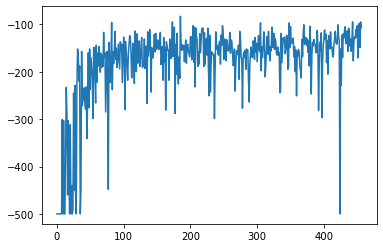

In [6]:
def play_episode(env, agent, max_episode_steps=None, mode=None, render=False):
    observation, reward, done = env.reset(), 0., False
    agent.reset(mode=mode)
    episode_reward, elapsed_steps = 0., 0
    while True:
        action = agent.step(observation, reward, done)
        if render:
            env.render()
        if done:
            break
        observation, reward, done, _ = env.step(action)
        episode_reward += reward
        elapsed_steps += 1
        if max_episode_steps and elapsed_steps >= max_episode_steps:
            break
    agent.close()
    return episode_reward, elapsed_steps


logging.info('==== train ====')
episode_rewards = []
for episode in itertools.count():
    episode_reward, elapsed_steps = play_episode(env.unwrapped, agent,
            max_episode_steps=env._max_episode_steps, mode='train')
    episode_rewards.append(episode_reward)
    logging.debug('train episode %d: reward = %.2f, steps = %d',
            episode, episode_reward, elapsed_steps)
    if np.mean(episode_rewards[-10:]) > -120:
        break
plt.plot(episode_rewards)


logging.info('==== test ====')
episode_rewards = []
for episode in range(100):
    episode_reward, elapsed_steps = play_episode(env, agent)
    episode_rewards.append(episode_reward)
    logging.debug('test episode %d: reward = %.2f, steps = %d',
            episode, episode_reward, elapsed_steps)
logging.info('average episode reward = %.2f ± %.2f',
        np.mean(episode_rewards), np.std(episode_rewards))

In [7]:
env.close()